# BindsNet Encoders

## 1. Table of Contents
1. Table of Contents
2. Overview
2. Import Statements
3. Encoders
    1. Poisson Encoders
    2. Bernoulli Encoders
    3. Rank Order Encoder

## 2. Overview
All of the encoders below transform an N dimensional input tensor into an N + 1 dimensional tensor, where the added dimension is time. The data fed into the encoders must all be floating point values. This is because some of the encoders perform divisions using the data that could approximate to fractional values.

## 3. Import Statements

In [72]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from time import time as t

from bindsnet.encoding import *

## 3c. Poisson Encoder

### Summary
Generates Poisson-distributed spike trains based on input intensity. Inputs must be non-negative, and give the firing rate in Hz. Inter-spike intervals (ISIs) for non-negative data incremented by one to avoid zero intervals while maintaining ISI distributions.

### Limitations
* Inputs must be non-negative
* Inputs must be floating point numbers (otherwise the rate will zero out)

### Rate Calculation

1. Compute firing rates in seconds as a function of data intensity
    * rate = (1 / input_intensity) * (1000 / dt)
    * higher intensity -> lower inter-spike interaval
    * dt = simulation time step
2. Create Poisson distribution and sample inter-spike intervals
    * `torch.distributions.Poisson()` used to generate samples
    * `time/dt` samples are taken for each input element based on the probability density function (pdf) of a Poisson distribution
        * Vales near the rate (lambda) more likely to occur
        * The higher the rate, the more varied the data will be
    * if any samples produced 0, set them to 1
3. Incrementally add all of the samples generated for each input element
    * this produces indexes of where to set the spike outputs for each element in the spikes array
    * if any samples are greater than `time/dt`, set them to 0 because they are outside of the sample duration
4. Create tensor of spikes
    * for each of the indexes produced, set the corresponding indexes in the spike tensor to 1
    * given an input tensor with dimsnions X x Y, the output tensor has dimensions (time/dt + 1) x X x Y
    * remove the first row of spikes because they are all set to 1
5. Summary
    * samples = time/dt
    * rate = (1/intensity)*(1000/dt)
    * intervals = torch.distributions.Poisson(rate=rate).sample(sample_shape=samples)
    * times = torch.cumsum(intervals,dim=0).long()
    * spikes\[times] = 1

### Poisson Distribution

![Poisson Probability Function](https://wikimedia.org/api/rest_v1/media/math/render/svg/c22cb4461e100a6db5f815de1f44b1747f160048)

![Poisson Probability Graph Function](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Poisson_pmf.svg/325px-Poisson_pmf.svg.png)

where
* k is the number of occurrences
* λ is the rate (mean number of occurrences in the interval)

(Source [wikipedia.org](https://en.wikipedia.org/wiki/Poisson_distribution))

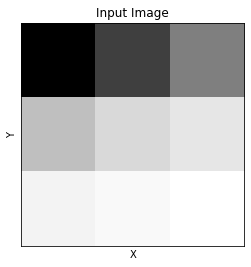

Input Datum:
[[100.   75.   50. ]
 [ 25.   15.   10. ]
 [  5.    2.5   0. ]]

Rates for Each Element:
Rate for 100.0: 10 Hz (Approx. 1 spike per 1.0 time steps.)
Rate for 75.0: 7 Hz (Approx. 1 spike per 1.33 time steps.)
Rate for 50.0: 5 Hz (Approx. 1 spike per 2.0 time steps.)
Rate for 25.0: 2 Hz (Approx. 1 spike per 4.0 time steps.)
Rate for 15.0: 2 Hz (Approx. 1 spike per 6.67 time steps.)
Rate for 10.0: 1 Hz (Approx. 1 spike per 10.0 time steps.)
Rate for 5.0: 0 Hz (Approx. 1 spike per 20.0 time steps.)
Rate for 2.5: 0 Hz (Approx. 1 spike per 40.0 time steps.)
Rate for 0.0: 0 Hz (Approx. 1 spike per 0 time steps.)

Encoded Datum:


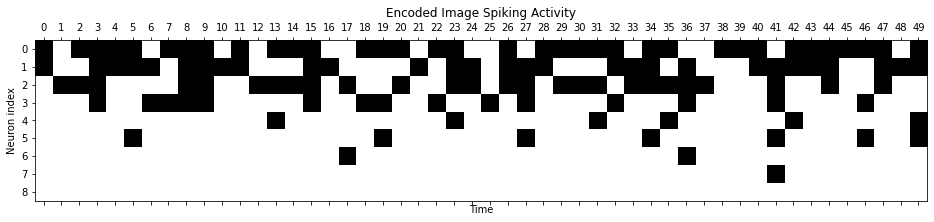

In [75]:
# time is the total sample duration in ms
time = 500

# dt is the step size within the sample duration in ms
dt = 10

# num_steps is how many steps are generated based on the time and dt values
num_steps = int(time/dt)

# input data
train_image = torch.FloatTensor([[100,75,50],[25,15,10],[5,2.5,0]])

# show input image
plt.matshow(train_image, cmap='binary')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Input Image')
plt.show()

# print train data
print("Input Datum:")
print("======================")
print(train_image.numpy())
print()

# rates
print("Rates for Each Element:")
print("======================")
for element in train_image.flatten():
    period = ((1/element.item())*(1000/dt)) if (element.item() != 0) else 0
    rate = 1 / period if period != 0 else 0
    
    print("Rate for "+str(element.item())+":",round(rate*dt),"Hz","(Approx. 1 spike per",round(period,2),"time steps.)")
print()

# create encoder and encode input
encoder = PoissonEncoder(time=time, dt=dt)
encoded_image = encoder(train_image)
print("Encoded Datum:")
print("======================")

# Look at input spiking activity.
encoded_image = np.reshape(encoded_image,(num_steps,train_image.nelement())).T
plt.matshow(encoded_image, cmap='binary')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Encoded Image Spiking Activity')
plt.yticks(np.arange(train_image.nelement()))
plt.xticks(np.arange(num_steps))
plt.show()

## 3d. Bernoulli Encoder
### Summary
Generates Bernoulli-distributed spike trains based on input intensity. Inputs must be non-negative. Spikes correspond to successful Bernoulli trials, with success probability equal to (normalized in \[0, 1]) input value. A maximum probability can be set using the `max_prob` argument

### Limitations
* Inputs must be non-negative
* Inputs must be floating point numbers (otherwise the rate will zero out)

### Bernoulli Trial Calculation
1. Inputs are normalized based on the max intensity
    * The highest intensity will have a probability of 1 and always spike
    * An intensity of 0 will have a probability of 0 and never spike
2. The spike tensor is generated using `torch.bernoulli()` to generate the random samples
    * Highest intensity will always produce 1, lower intensities will generate 1's based on their scale against the highest intensity

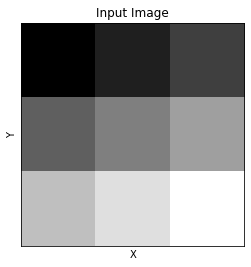

Input Datum:
tensor([[80., 70., 60.],
        [50., 40., 30.],
        [20., 10.,  0.]])

Probabilities of Spiking for Each Element per time step:
Probability for 80.0 to spike per time step: 100%
Probability for 70.0 to spike per time step: 88%
Probability for 60.0 to spike per time step: 75%
Probability for 50.0 to spike per time step: 62%
Probability for 40.0 to spike per time step: 50%
Probability for 30.0 to spike per time step: 38%
Probability for 20.0 to spike per time step: 25%
Probability for 10.0 to spike per time step: 12%
Probability for 0.0 to spike per time step: 0%

Encoded Datum:



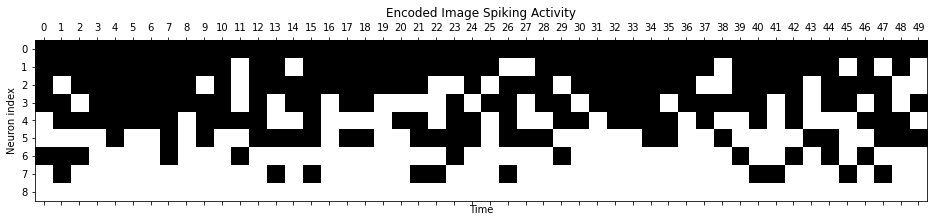

In [76]:
# time is the total sample duration in ms
time = 50

# dt is the step size within the sample duration in ms
dt = 1.0

# num_steps is how many steps are generated based on the time and dt values
num_steps = int(time/dt)

# input data
train_image = torch.FloatTensor([[80,70,60],[50,40,30],[20,10,0]])

# show input image
plt.matshow(train_image, cmap='binary')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Input Image')
plt.show()

# print train data
print("Input Datum:")
print("======================")
print(train_image)
print()

# probabilities
print("Probabilities of Spiking for Each Element per time step:")
print("======================")
for element in train_image.flatten():
    prob = (element.item() / train_image.max()) * 100
    print("Probability for "+str(element.item())+" to spike per time step:",str(round(prob.item()))+"%")
print()

# create encoder and encode input
encoder = BernoulliEncoder(time=time, dt=dt)
encoded_image = encoder(train_image)
print("Encoded Datum:")
print("======================")
#print(encoded_image)
print()

# Look at input spiking activity.
encoded_image = np.reshape(encoded_image,(num_steps,train_image.nelement())).T
plt.matshow(encoded_image, cmap='binary')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Encoded Image Spiking Activity')
plt.yticks(np.arange(train_image.nelement()))
plt.xticks(np.arange(num_steps))
plt.show()

## 3e. Rank Order Encoder
### Summary
Encodes data via a rank order coding-like representation. One spike per neuron, temporally ordered by decreasing intensity. Inputs must be non-negative.

### Rank Calculations
1. Normalize data based on the max value
2. Invert the data to get the times
    * Higher Values correspond to Lower Times
3. Divide the data by the max time
    * Time values are rounded up to the next value and converted to int to get the ranks
4. For each element, if the rank is within `time/dt` time steps, assign a spike to the time step corresponding to the rank

### Limitations
* Elements need to be widely varied to avoid rank overlap
* The same rank can repeat multiple times

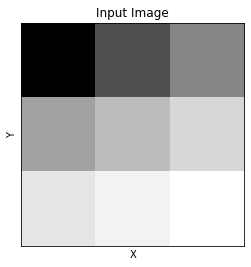

Input Datum:
[[100.  70.  50.]
 [ 40.  30.  20.]
 [ 15.  10.   5.]]

Ranks of Spiking for Each Element per time step:
Rank for 100.0 is: 2
Rank for 70.0 is: 2
Rank for 50.0 is: 3
Rank for 40.0 is: 4
Rank for 30.0 is: 5
Rank for 20.0 is: 7
Rank for 15.0 is: 9
Rank for 10.0 is: 13
Rank for 5.0 is: 25

Encoded Datum:



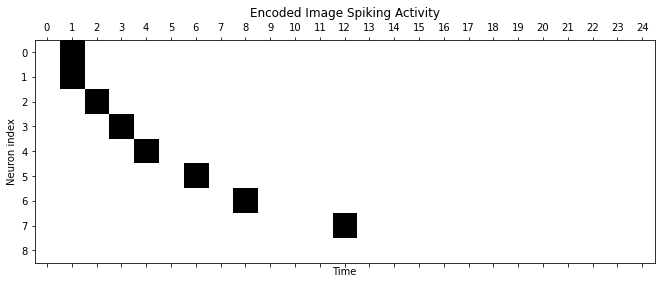

Rank Plot:


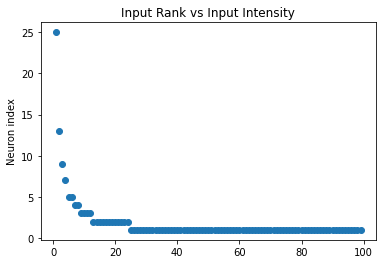

In [84]:
# time is the total sample duration in ms
time = 25

# dt is the step size within the sample duration in ms
dt = 1.0

# num_steps is how many steps are generated based on the time and dt values
num_steps = int(time/dt)

# input data
train_image = torch.FloatTensor([[100,70,50],[40,30,20],[15,10,5]])

# show input image
plt.matshow(train_image, cmap='binary')
plt.xticks(())
plt.yticks(())
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Input Image')
plt.show()

# print train data
print("Input Datum:")
print("======================")
print(train_image.numpy())
print()

# ranks
print("Ranks of Spiking for Each Element per time step:")
print("======================")
datum = train_image.clone()
datum = (datum / datum.max()).flatten()
times = torch.zeros(datum.numel())
times[datum != 0] = 1 / datum[datum != 0]
times *= time / times.max()
times = torch.ceil(times).long()
for idx in range(len(train_image.flatten().tolist())):
    elements = train_image.flatten().tolist()
    print("Rank for "+str(round(elements[idx],2))+" is:",str(times[idx].item()))
print()

# create encoder and encode input
encoder = RankOrderEncoder(time=time, dt=dt)
encoded_image = encoder(train_image.clone())
print("Encoded Datum:")
print("======================")
print()

# Look at input spiking activity.
encoded_image = np.reshape(encoded_image,(num_steps,train_image.nelement())).T
plt.matshow(encoded_image, cmap='binary')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Encoded Image Spiking Activity')
plt.yticks(np.arange(train_image.nelement()))
plt.xticks(np.arange(num_steps))
plt.show()

print("Rank Plot:")
max_intensity = int(train_image.max().numpy())
x = torch.arange(1,max_intensity,1).float()
plt.ylabel('Input Rank')
plt.xlabel('Input Intensity')
plt.title('Input Rank vs Input Intensity')
x_times = (1/(x / max_intensity))
x_times_max = x_times.max().numpy()
x_times *= (time/dt) / x_times_max
ranks = torch.ceil(x_times).long()
plt.scatter(x,ranks)
plt.show()